**Coin detection and Total value**


---


  This code is designed to find coins in a picture and figure out how much they're worth. It starts by loading a picture and changing its color format to make it easier to work with. Then, it cleans up the picture by sharpening it and removing noise.

  Next, it tries to identify objects that look like coins based on their size and color. It has a special function that can tell different coins apart, like pennies, nickels, dimes, and quarters, by looking at how big they are and how bright or dull they appear.

  To separate each coin, it uses a technique called "watershed," which is like imagining the picture as a landscape and letting water flow down to create boundaries. Once it has isolated each coin, it double-checks its size and shape to make sure it's actually a coin.

  If it's sure it's a coin, it uses the special function to determine its value and draws a box around it in the picture. Finally, it shows you the picture with all the coins labeled and their values, and it adds up the total value of all the coins it found.

Part 1: Image Uploading


---


*   Upload Image(s) to Process



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving coins_easy7.jpg to coins_easy7.jpg


***Part 2: Conversion***


---



*  Open images and convert to HSV (Hue, Saturation, & Value)



In [ ]:
# Part 2: convert To HSV
import cv2 as cv2
img_HSV=[] #array (list) of HSV images
filename=[] #array (list) of file names
i=0
for fn in uploaded.keys(): #for each filename
  filename.append(fn) #append to filenames array
  #open the uploaded image file and convert from BGR to HSV
  hsv = cv2.cvtColor(cv2.imread(filename[i]), cv2.COLOR_BGR2HSV)
  #hsv is single image with 3 channels (H, S, V)
  img_HSV.append(cv2.split(hsv))  #split to array of 3 images, add to HSV array
  i = i + 1
print('Converted '+str( len(img_HSV) )+' images') # display image conversion
Vdim = hsv.shape[0] #rows
Hdim = hsv.shape[1] #cols
print('Hdim: ' + str(Hdim) + '; Vdim: ' + str(Vdim))

Converted 1 images
Hdim: 1700; Vdim: 1300


***Part 3: Image Pre-Processing***


---


*   This section processes images to enhance contrast and prepare them for segmentation. The code extracts the Value channel from HSV images, applies Gaussian Blur to reduce noise, and enhances contrast using CLAHE also used canny edge after the.
*   Otsu's thresholding is then applied to convert the image into a binary format, making it easier to detect objects. Morphological operations help clean up small noise, and the processed images are displayed using Matplotlib.





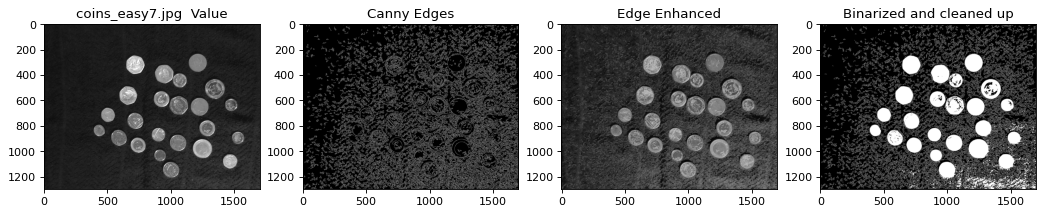

In [ ]:
#part3: image pre-processing
from matplotlib import pyplot as plt
import numpy as np

morph_size =8 #clean-up binary regions smaller than this value

bin_img =[] # this is a bin to store our image(1600x1600) for displaying our processed image.

#Morhpological gradient processing (dilation & erosion) used for cleanup
element=cv2.getStructuringElement(cv2.MORPH_RECT,(morph_size,morph_size))

i=0
for img in img_HSV: #for each image in the array of HSV images
  value_channel = img[2] #use Value from (H,S,V)channel(illumination)


# Ensure value_channel is 8-bit grayscale
  value_channel = value_channel.astype(np.uint8)
# Apply Gaussian Blur
  blurred_V_channel = cv2.GaussianBlur(value_channel, (5, 5), 0)
# Apply CLAHE (Contrast Limited Adaptive Histograms)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
  Blurred_clahe_v_channel = clahe.apply(blurred_V_channel)
  # Add Canny edge detection
  edges = cv2.Canny(Blurred_clahe_v_channel, 50, 150)
  # Combined the canny edge information with the CLAHE image
  # This helps watershed algorithm by emphasizing boundaries
  edge_enhanced = cv2.addWeighted(Blurred_clahe_v_channel, 0.7, edges, 0.3, 0)

  # Apply Otsu's thresholding on the edge-enhanced image
  _, otsu_thresh = cv2.threshold(edge_enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Update bin_img with the new updated thresholded image
  bin_img.append(otsu_thresh)

  # Display with pyplot
  fig = plt.figure(figsize=(16, 6), dpi=80)
  ax = fig.add_subplot(141, aspect='auto')
  ax.imshow(img[2], cmap='gray', vmin=0, vmax=255)
  ax.set_title(filename[i] + '  Value')

  ax = fig.add_subplot(142, aspect='auto')
  ax.imshow(edges, cmap='gray', vmin=0, vmax=255)
  ax.set_title('Canny Edges')

  ax = fig.add_subplot(143, aspect='auto')
  ax.imshow(edge_enhanced, cmap='gray', vmin=0, vmax=255)
  ax.set_title('Edge Enhanced')

  ax = fig.add_subplot(144, aspect='auto')
  ax.imshow(bin_img[i], cmap='gray', vmin=0, vmax=255)
  ax.set_title('Binarized and cleaned up')

***Part 4: Classification***


---


*   Classification is used to define the coins from non-coins. done through using the function

```
 def classify(x,y,w,h,area,img_idx):
```

the main purpose of this section is to determine if a detected object in the image imported is a coin and, if so what type of coin it is.




In [ ]:
#Part 4: Classificication

#input: ROI coords (top left, width, height), blob area, image number
#output: coin value (-1 if unknown), mean Sat at centre, mean sat on sides
#accesses Saturation image as well
def classify(x,y,w,h,area,img_idx):
  size = (w+h)/2
  #check mean Saturation in central region
  im = img_HSV[img_idx][1] #Sat component
  sub_img = im[y+h//3:y+2*h//3, x+w//3:x+2*w//3]
  mcenter = cv2.mean(sub_img)
  meanSatcenter = mcenter[0]
  #check mean Saturation in 4 side regions
  sub_img = im[y+h//3:y+2*h//3, x+5:x+w//5] #left
  mside = cv2.mean(sub_img)
  meanSatside = mside[0]
  sub_img = im[y+4*h//5:y+h-5, x+w//3:x+2*w//3] #down
  mside = cv2.mean(sub_img)
  meanSatside = meanSatside + mside[0]
  sub_img = im[y+h//3:y+2*h//3, x+4*w//5:x+w-5] #right
  mside = cv2.mean(sub_img)
  meanSatside = meanSatside + mside[0]
  sub_img = im[y+5:y+h//5, x+w//3:x+2*w//3] #top
  mside = cv2.mean(sub_img)
  meanSatside = meanSatside + mside[0]
  meanSatside = meanSatside // 4
  ###### Classify using sizes and mean Saturation #####
  if size < 80 or size > 160 and meanSatside < 30 : # not a coin
        return (-1, 0, 0)
  if meanSatcenter < 10 and meanSatside < 25:
      return (-1, 0, 0)  # Not a coin if both saturations are very low (washer or random object)

  if size < 96:  # 5p
      return (0.05, meanSatcenter, meanSatside)

  if size <= 108:  # 1p or 5p (if not coloured)
        return (0.05, meanSatcenter, meanSatside) if meanSatcenter < 100 else (0.01, meanSatcenter, meanSatside)

  if size <= 147.5:  # £2.00, 20p, £1.00, 2p, 10p, 50p
        if size <= 120:
            return (0.20, meanSatcenter, meanSatside) #20p
        elif size <= 126:
            return (1.00, meanSatcenter, meanSatside) #£1.00

        elif size <= 131 and meanSatcenter > 100: #£0.02
            return (0.02, meanSatcenter, meanSatside)  #2p

        elif size <= 135 and meanSatcenter < 105:
            return (0.10, meanSatcenter, meanSatside) #10p

        elif 132 <= size < 138: #50p
            return (0.50, meanSatcenter, meanSatside)   #50p
        else:
            return (2.00, meanSatcenter, meanSatside)#£2.00

  return (-1, 0, 0)  # Unknown coin

Part 5: Segmentation

---




Blob 2 IS COIN
Value=2.0
Blob 3 IS COIN
Value=2.0
Blob 4 IS COIN
Value=2.0
Blob 5 IS COIN
Value=2.0
Blob 6 IS COIN
Value=2.0
Blob 7 IS COIN
Value=0.05
Blob 8 IS COIN
Value=0.05
Blob 9 IS COIN
Value=1.0
Blob 10 IS COIN
Value=1.0
Blob 11 IS COIN
Value=0.05
Blob 12 IS COIN
Value=0.01
Blob 13 IS COIN
Value=0.05
Blob 14 IS COIN
Value=0.1
Blob 15 IS COIN
Value=0.2
Blob 16 IS COIN
Unknown value!
Blob 17 IS COIN
Value=0.05
Blob 18 IS COIN
Value=0.2
Blob 19 IS COIN
Value=1.0


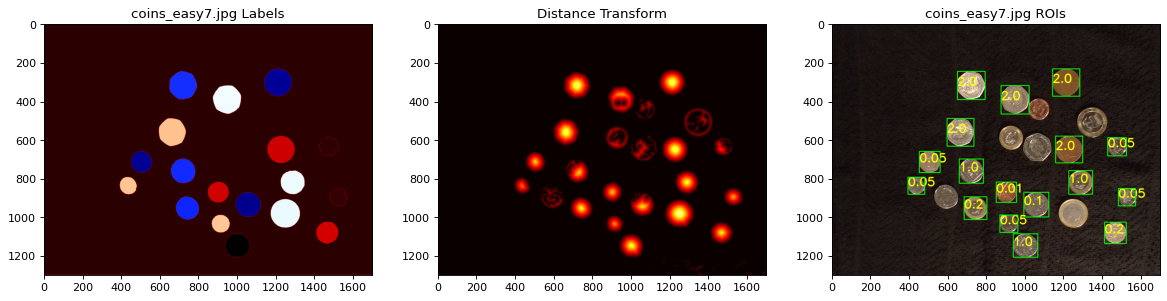

TOTAL: £13.760000000000002


In [ ]:
# Part 5: Segmentation
image_to_use = 0  #  Using the first image from the uploaded set

# Create output file
fname = 'result_' + filename[image_to_use] + '.csv'# Create output filename
fp = open(fname, 'w')
fp.write('x1,y1,w,h,SatCent,SatSides,Value\n')
TotalValue = 0 # Initialize counter for total coin value

# Load original image and convert  to rgb then to gray scale
imgRGB = cv2.cvtColor(cv2.imread(filename[image_to_use]), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)

# Convert binary image to numpy array
bin_img_np = np.array(bin_img[image_to_use])

# Noise removal with morphological opening
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(bin_img_np, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area - dilated opening
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
# Distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
# Threshold distance transform
ret, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that background is not 0, but 1
markers = markers + 1
# Mark the unknown region with zero
markers[unknown == 255] = 0

# Apply watershed
markers = cv2.watershed(imgRGB, markers)

# Process results
for label in np.unique(markers):
    # Skip background (1) and watershed boundaries (0)
    if label <= 1:
        continue

    # Create mask for current label
    mask = np.zeros_like(gray, dtype=np.uint8)
    mask[markers == label] = 255

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        cnt = contours[0]
        area = cv2.contourArea(cnt)

        # Only process larger blobs (potential coins)
        if area > 1000:
            x1, y1, w, h = cv2.boundingRect(cnt)
            aspect_ratio = float(w) / h

            # Check if the blob is approximately circular
            if 0.8 < aspect_ratio < 1.2:
                print(f'Blob {label} IS COIN')
                value, SatC, SatSide = classify(x1, y1, w, h, area, image_to_use)

                if value == -1:
                    print('Unknown value!')
                    # Don't draw bounding box for unknown values
                else:
                    # Add value text
                    cv2.putText(imgRGB, str(value), (int(x1), int(y1 + h/2)),
                                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 6)
                    print('Value=' + str(value))
                    TotalValue += value
                    fp.write(f'{x1},{y1},{w},{h},{int(SatC)},{int(SatSide)},{value}\n')
                    # Draw bounding box for valid coins
                    cv2.rectangle(imgRGB, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 3)

fp.close()

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
axes[0].imshow(markers, cmap='flag', vmin=0, vmax=np.max(markers))
axes[0].set_title(filename[image_to_use] + ' Labels')

axes[1].imshow(dist_transform, cmap='hot')
axes[1].set_title('Distance Transform')

axes[2].imshow(imgRGB)
axes[2].set_title(filename[image_to_use] + ' ROIs')
plt.show()

print('TOTAL: £' + str(TotalValue))